
# CHEW DETECTION ANALYSIS: BORIS ANNOTATIONS vs AUTOMATED PEAK DETECTION

# Project Overview
# 
This notebook validates an automated chew detection pipeline by comparing algorithmically detected peaks in nose-mouth distance measurements against ground-truth annotations from BORIS behavioral observation software. The distance measurements were obtained from a deep learning model trained on 500 manually labeled video frames using the CURTA cluster. The pipeline processes the distance time series through resampling, smoothing, and peak detection stages, then evaluates detection accuracy across defined video bouts by computing per-bout and aggregate error metrics. The primary goal is to assess whether the automated detection can reliably identify chewing events with sufficient accuracy to replace or augment manual annotation workflows.


#  Import Libraries and Configuration

This cell imports all required libraries for signal processing, data manipulation, and visualization. The configuration parameters control the entire pipeline including file paths, video timing synchronization, signal processing parameters for resampling and smoothing, and peak detection thresholds. The VIDEO_BOUTS define time windows in accelerometer coordinates that must be mapped to video time using VIDEO_START_ACCEL offset, while detection parameters like PEAK_DISTANCE_S and PEAK_PROMINENCE control the sensitivity and specificity of the automated chew identification algorithm.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import median_filter
from matplotlib.patches import Patch
from IPython.display import display

# Configure matplotlib
plt.style.use('default')
%matplotlib inline

# ==================== CONFIGURATION ====================
# File paths
DISTS_CSV = r"C:\Users\Michelangelo\Desktop\dists_all.csv"
BORIS_CSV = r"C:\Users\Michelangelo\Desktop\boris_video3.csv"

# Video bout definitions (in accelerometer seconds)
VIDEO_BOUTS = [
    (374.8, 424.8), (428.8, 489.8), (493.8, 532.8), (539.8, 602.8), (607.8, 669.8),
    (674.8, 734.8), (738.8, 794.8), (802.8, 860.8), (866.8, 923.8), (927.8, 930.8)
]

# Time synchronization
VIDEO_START_ACCEL = 349.75  # Offset to convert accelerometer time to video time
FPS = 30.0                   # Video frame rate

# Signal processing parameters
RESAMPLE_HZ = 100.0          # Resampling frequency for uniform time grid
SMOOTH_WINDOW_S = 0.12       # Smoothing window for peak detection (seconds)
FULL_SMOOTH_S = 0.25         # Smoothing window for visualization (seconds)

# Peak detection parameters
PEAK_DISTANCE_S = 0.5        # Minimum time between peaks (seconds)
PEAK_PROMINENCE = None       # Auto-calculated if None (MAD-based heuristic)
PEAK_POLARITY = 'max'        # 'max' for positive peaks, 'min' for negative
PROM_MULT = 0.5              # Multiplier for MAD-based prominence
PROM_ABS = 12.517            # Absolute minimum prominence threshold

# Visualization parameters
ZOOM_WINDOW_S = 10.0         # Zoom window duration (seconds)
N_BOUTS_TO_SHOW = 5          # Number of bouts to plot in detail

print("Configuration loaded successfully")
print(f"Processing {len(VIDEO_BOUTS)} video bouts")


Configuration loaded successfully
Processing 10 video bouts


# Data Loading and Column Detection
# 
This cell loads the distance CSV file and implements robust column detection heuristics to handle various naming conventions. The code searches for distance columns using common patterns like d_px, dpx, d_norm, or distance, falling back to the first numeric column if no match is found. Similarly, it detects time or frame columns to establish the temporal axis. After column identification, the data is sorted by frame or time to ensure monotonic ordering, which is critical for subsequent interpolation and peak detection steps. This flexible approach makes the pipeline resilient to minor variations in data format without requiring manual configuration.


In [4]:
# Load CSV with automatic delimiter detection
df_raw = pd.read_csv(DISTS_CSV, sep=None, engine='python')
print(f"Loaded CSV with shape: {df_raw.shape}")
print(f"Columns detected: {list(df_raw.columns)}")

# Detect distance column using priority list
cols_lower = {c.lower(): c for c in df_raw.columns}
DIST_COL = None
for candidate in ('d_px', 'dpx', 'd_norm', 'distance', 'd'):
    if candidate in cols_lower:
        DIST_COL = cols_lower[candidate]
        break

# Fallback to first numeric column if no match
if DIST_COL is None:
    numeric_cols = [c for c in df_raw.columns if pd.api.types.is_numeric_dtype(df_raw[c])]
    if not numeric_cols:
        raise RuntimeError("No numeric column found for distance measurements")
    DIST_COL = numeric_cols[0]
    print(f"Warning: Using fallback distance column '{DIST_COL}'")

# Detect time/frame columns
TIME_COL = None
FRAME_COL = None
for candidate in ('time_s', 'time', 'timestamp', 't'):
    if candidate in cols_lower:
        TIME_COL = cols_lower[candidate]
        break
if 'frame' in cols_lower:
    FRAME_COL = cols_lower['frame']

print(f"\nUsing distance column: '{DIST_COL}'")
print(f"Using time column: '{TIME_COL}' (frame column: '{FRAME_COL}')")

# Sort data by frame or time for monotonic ordering
df = df_raw.copy()
if FRAME_COL is not None:
    df[FRAME_COL] = pd.to_numeric(df[FRAME_COL], errors='coerce')
    df = df.sort_values(FRAME_COL).reset_index(drop=True)
    print(f"Data sorted by frame column: {FRAME_COL}")
elif TIME_COL is not None:
    df[TIME_COL] = pd.to_numeric(df[TIME_COL], errors='coerce')
    df = df.sort_values(TIME_COL).reset_index(drop=True)
    print(f"Data sorted by time column: {TIME_COL}")

display(df.head(6))

Loaded CSV with shape: (20072, 9)
Columns detected: ['filename', 'frame', 'time_s', 'nose_x', 'nose_y', 'mouth_x', 'mouth_y', 'd_px', 'd_norm']

Using distance column: 'd_px'
Using time column: 'time_s' (frame column: 'frame')
Data sorted by frame column: frame


,filename,frame,time_s,nose_x,nose_y,mouth_x,mouth_y,d_px,d_norm
0,20250811_110514_rotCW_1.txt,1,0.033333,565.82172,1186.89600,461.25504,1359.87072,202.124824,0.091754
1,20250811_110514_rotCW_2.txt,2,0.066667,564.95772,1185.93984,455.14008,1365.42528,210.416105,0.095517
2,20250811_110514_rotCW_3.txt,3,0.100000,569.21832,1185.72096,460.23552,1360.27392,205.781405,0.093414
3,20250811_110514_rotCW_4.txt,4,0.133333,569.04336,1184.34816,462.82536,1356.48000,202.266245,0.091818
4,20250811_110514_rotCW_5.txt,5,0.166667,575.69076,1198.40832,510.19632,1349.27232,164.467225,0.074659
5,20250811_110514_rotCW_6.txt,6,0.200000,543.42684,1211.99040,636.50880,1335.22560,154.438226,0.070107


# Time Axis Construction and Data Cleaning
# 
This cell constructs a continuous time axis in video seconds using a hierarchical approach that prioritizes direct time measurements over frame-based calculations. When a time column exists it is used directly, otherwise frame numbers are converted to seconds using the formula (frame - 1) / FPS to ensure frame 1 maps to t=0. The distance measurements are converted to numeric format with error handling, and all invalid samples containing NaN values in either time or distance are removed. The final step sorts the cleaned data by time to guarantee monotonic ordering, which is essential for correct interpolation during the resampling phase. This preprocessing ensures robust handling of common data quality issues like missing values, non-numeric entries, and temporal gaps.


In [5]:
# Build time vector with frame-1 adjustment for 0-based indexing
if TIME_COL is not None:
    t_raw = pd.to_numeric(df[TIME_COL], errors='coerce').to_numpy()
elif FRAME_COL is not None:
    # Convert frame to seconds: (frame - 1) / FPS so frame 1 -> 0s
    frames = pd.to_numeric(df[FRAME_COL], errors='coerce').to_numpy()
    t_raw = (frames - 1.0) / FPS
else:
    # Fallback: assume uniform sampling
    t_raw = np.arange(len(df), dtype=float) / FPS
    print("Warning: No time/frame column found, assuming uniform sampling")

# Convert distance column to numeric
d_raw = pd.to_numeric(df[DIST_COL], errors='coerce').to_numpy()

# Validate that we have numeric data
if not np.isfinite(t_raw).any() or not np.isfinite(d_raw).any():
    raise RuntimeError(
        f"No valid numeric samples in time or distance columns. "
        f"Check CSV format. Columns: {', '.join(df.columns)}"
    )

# Remove invalid samples (NaN in either time or distance)
valid_mask = np.isfinite(t_raw) & np.isfinite(d_raw)
n_invalid = np.sum(~valid_mask)
if n_invalid > 0:
    print(f"Removed {n_invalid} invalid samples ({100*n_invalid/len(t_raw):.2f}%)")
    t_raw = t_raw[valid_mask]
    d_raw = d_raw[valid_mask]

# Ensure monotonic time ordering
if not np.all(np.diff(t_raw) >= 0):
    sort_order = np.argsort(t_raw)
    t_raw = t_raw[sort_order]
    d_raw = d_raw[sort_order]
    print("Data re-sorted by time to ensure monotonic ordering")

print(f"\nCleaned data: {len(t_raw)} valid samples")
print(f"Time range: {t_raw[0]:.2f}s to {t_raw[-1]:.2f}s (duration: {t_raw[-1]-t_raw[0]:.2f}s)")
print(f"Distance range: {np.min(d_raw):.2f} to {np.max(d_raw):.2f} pixels")


Cleaned data: 20072 valid samples
Time range: 0.03s to 581.67s (duration: 581.63s)
Distance range: 61.88 to 253.15 pixels


# Signal Resampling to Uniform Grid
# 
This cell resamples the irregular time series onto a uniform temporal grid at the specified RESAMPLE_HZ frequency using linear interpolation. Uniform sampling is required for consistent application of smoothing filters and peak detection algorithms that assume equal time steps between samples. The resampling process computes the target number of samples based on the time span and desired frequency, then interpolates the distance values at each new time point. This standardization step eliminates timing jitter from the original acquisition system and provides a consistent temporal resolution for all subsequent processing stages, enabling reliable comparison of measurements across different time windows.


In [6]:
# Validate resampling frequency
if RESAMPLE_HZ <= 0:
    raise ValueError("RESAMPLE_HZ must be positive")

# Calculate uniform time grid
t_start, t_end = float(t_raw[0]), float(t_raw[-1])
n_samples = int(np.floor((t_end - t_start) * RESAMPLE_HZ)) + 1
new_t = t_start + np.arange(n_samples) / RESAMPLE_HZ

# Interpolate distance values onto uniform grid
new_d = np.interp(new_t, t_raw, d_raw)

print(f"Resampled from {len(t_raw)} to {len(new_t)} samples at {RESAMPLE_HZ} Hz")
print(f"Original sampling rate: {len(t_raw)/(t_end-t_start):.1f} Hz (avg)")
print(f"New time step: {1/RESAMPLE_HZ*1000:.2f} ms")

Resampled from 20072 to 58164 samples at 100.0 Hz
Original sampling rate: 34.5 Hz (avg)
New time step: 10.00 ms


# Signal Smoothing for Peak Detection
# 
This cell applies temporal smoothing to reduce high-frequency noise and facilitate robust peak detection. A centered rolling mean filter with window duration SMOOTH_WINDOW_S is applied to the resampled signal, converting the window size from seconds to samples based on the resampling frequency. The centered window ensures that each smoothed value represents the local neighborhood symmetrically around that time point, minimizing temporal shift artifacts. This smoothing step is critical for peak detection as it suppresses measurement noise and transient fluctuations that could generate false positive detections, while preserving the genuine periodic chewing signal. The smoothed trace is used exclusively for detection, while a separate visualization smoothing is applied later for plotting clarity.


In [7]:
# Calculate smoothing window size in samples
smooth_window_samples = max(1, int(round(SMOOTH_WINDOW_S * RESAMPLE_HZ)))

# Apply centered rolling mean for detection
d_smooth = pd.Series(new_d).rolling(
    window=smooth_window_samples, 
    center=True, 
    min_periods=1
).mean().to_numpy()

print(f"Applied smoothing: window = {smooth_window_samples} samples (~{SMOOTH_WINDOW_S}s)")
print(f"Smoothing reduces noise while preserving chewing periodicity")

# Calculate signal statistics for prominence estimation
signal_median = np.nanmedian(d_smooth)
signal_mad = np.nanmedian(np.abs(d_smooth - signal_median))
signal_range = np.nanmax(d_smooth) - np.nanmin(d_smooth)

print(f"\nSignal statistics after smoothing:")
print(f"  Median: {signal_median:.2f} pixels")
print(f"  MAD (robust std): {signal_mad:.2f} pixels")
print(f"  Range: {signal_range:.2f} pixels")

Applied smoothing: window = 12 samples (~0.12s)
Smoothing reduces noise while preserving chewing periodicity

Signal statistics after smoothing:
  Median: 173.15 pixels
  MAD (robust std): 16.83 pixels
  Range: 183.85 pixels


# Automated Peak Detection
# 
This cell implements the core automated chew detection algorithm using scipy.signal.find_peaks with adaptive parameter selection. When PEAK_PROMINENCE is not manually specified, an automatic threshold is calculated using the Median Absolute Deviation (MAD) as a robust estimator of signal variability, scaled by PROM_MULT and floored by PROM_ABS to prevent over-sensitivity in low-noise regions. The algorithm respects PEAK_POLARITY to search for maxima or minima and enforces a minimum temporal separation of PEAK_DISTANCE_S between consecutive peaks to avoid detecting multiple peaks within a single chewing cycle. This combination of adaptive thresholding and temporal constraints produces a detection system that balances sensitivity and specificity across varying signal conditions without requiring manual tuning for each recording session.


In [8]:
# Determine peak prominence using MAD-based heuristic if not specified
if PEAK_PROMINENCE is None:
    # Calculate robust prominence threshold
    auto_prominence = max(PROM_ABS, signal_mad * PROM_MULT)
    peak_prominence = auto_prominence
    print(f"Auto-calculated prominence: {peak_prominence:.3f} pixels")
    print(f"  (MAD={signal_mad:.3f} × {PROM_MULT} with floor {PROM_ABS})")
else:
    peak_prominence = float(PEAK_PROMINENCE)
    print(f"Using manual prominence: {peak_prominence:.3f} pixels")

# Validate peak polarity
if PEAK_POLARITY not in ('max', 'min'):
    raise ValueError("PEAK_POLARITY must be 'max' or 'min'")

# Prepare signal for detection (invert if detecting minima)
detection_signal = d_smooth if PEAK_POLARITY == 'max' else -d_smooth

# Calculate minimum peak distance in samples
min_peak_distance_samples = max(1, int(round(PEAK_DISTANCE_S * RESAMPLE_HZ)))
print(f"Minimum peak separation: {PEAK_DISTANCE_S}s = {min_peak_distance_samples} samples")

# Detect peaks using scipy.signal.find_peaks
peaks_idx, peak_properties = find_peaks(
    detection_signal,
    prominence=peak_prominence,
    distance=min_peak_distance_samples
)

# Extract peak times and heights (in original signal space)
peak_times = new_t[peaks_idx]
peak_heights = d_smooth[peaks_idx]

print(f"\n{'='*60}")
print(f"PEAK DETECTION RESULTS")
print(f"{'='*60}")
print(f"Total peaks detected: {len(peaks_idx)}")
print(f"Detection rate: {len(peaks_idx)/(new_t[-1]-new_t[0]):.2f} peaks/second")
print(f"Mean inter-peak interval: {np.mean(np.diff(peak_times)) if len(peak_times)>1 else np.nan:.3f}s")

Auto-calculated prominence: 12.517 pixels
  (MAD=16.828 × 0.5 with floor 12.517)
Minimum peak separation: 0.5s = 50 samples

PEAK DETECTION RESULTS
Total peaks detected: 621
Detection rate: 1.07 peaks/second
Mean inter-peak interval: 0.936s


# BORIS Annotation Loading and Processing
# 
This cell loads the BORIS behavioral observation CSV file and extracts manually annotated chewing events marked with Start (S) and End (E) labels. The code implements flexible column detection heuristics to locate the time and behavior columns despite variations in naming conventions across different BORIS export formats. Time values are converted to numeric format with robust handling of various time representations including decimal seconds, HH:MM:SS strings, and timedelta objects. Each Start event is paired with its subsequent End event to compute the chewing episode midpoint as the mean of start and end times, producing a vector of ground-truth chew timestamps that serves as the validation reference for evaluating automated detection accuracy.


In [9]:
# Load BORIS CSV with automatic delimiter detection
boris_df = pd.read_csv(BORIS_CSV, sep=None, engine='python')
print(f"Loaded BORIS annotations: {boris_df.shape}")
print(f"Columns: {list(boris_df.columns)}")

# Detect BORIS time column
boris_cols_lower = {c.lower(): c for c in boris_df.columns}
BORIS_TIME_COL = None
for candidate in ('time', 'time_s', 't'):
    if candidate in boris_cols_lower:
        BORIS_TIME_COL = boris_cols_lower[candidate]
        break

# Fallback: search for column starting with 'time'
if BORIS_TIME_COL is None:
    for col in boris_df.columns:
        if col.strip().lower().startswith('time'):
            BORIS_TIME_COL = col
            break

if BORIS_TIME_COL is None:
    raise RuntimeError("No Time column found in BORIS CSV")

# Detect behavior column containing 'S'/'E' labels
BEHAVIOR_COL = None
for col in boris_df.columns:
    values = boris_df[col].astype(str).str.strip().str.lower()
    if values.isin(['s', 'e']).any():
        BEHAVIOR_COL = col
        break

# Fallback to 'behavior' column if exists
if BEHAVIOR_COL is None:
    for candidate in ('behavior', 'behaviour'):
        if candidate in boris_cols_lower:
            BEHAVIOR_COL = boris_cols_lower[candidate]
            break

print(f"\nUsing BORIS time column: '{BORIS_TIME_COL}'")
print(f"Using behavior column: '{BEHAVIOR_COL}'")

# Parse BORIS data
boris_df = boris_df.copy()
boris_df['time_numeric'] = pd.to_numeric(boris_df[BORIS_TIME_COL], errors='coerce')

if BEHAVIOR_COL is not None:
    boris_df['event'] = boris_df[BEHAVIOR_COL].astype(str).str.strip().str.upper()
else:
    boris_df['event'] = ''

# Extract Start and End events
start_times = boris_df.loc[boris_df['event'] == 'S', 'time_numeric'].dropna().astype(float).to_numpy()
end_times = boris_df.loc[boris_df['event'] == 'E', 'time_numeric'].dropna().astype(float).to_numpy()

# Sort events
start_times = np.sort(start_times)
end_times = np.sort(end_times)

print(f"\nBORIS events extracted:")
print(f"  Start events (S): {len(start_times)}")
print(f"  End events (E): {len(end_times)}")

# Pair each Start with next End to compute midpoints
chew_midpoints = []
end_idx = 0

for start in start_times:
    # Find next End after this Start
    while end_idx < len(end_times) and end_times[end_idx] <= start:
        end_idx += 1
    
    if end_idx < len(end_times):
        # Compute midpoint of S-E pair
        midpoint = 0.5 * (start + end_times[end_idx])
        chew_midpoints.append(midpoint)
        end_idx += 1

chew_midpoints_video = np.array(chew_midpoints, dtype=float)

print(f"\nBORIS S-E pairs (chew midpoints): {len(chew_midpoints_video)}")
print(f"Time range: {chew_midpoints_video[0]:.2f}s to {chew_midpoints_video[-1]:.2f}s")

Loaded BORIS annotations: (1206, 18)
Columns: ['Observation id', 'Observation date', 'Description', 'Observation duration', 'Observation type', 'Source', 'Time offset (s)', 'Media duration (s)', 'FPS', 'Subject', 'Behavior', 'Behavioral category', 'Behavior type', 'Time', 'Media file name', 'Image index', 'Image file path', 'Comment']

Using BORIS time column: 'Time'
Using behavior column: 'Behavior'

BORIS events extracted:
  Start events (S): 604
  End events (E): 602

BORIS S-E pairs (chew midpoints): 602
Time range: 1.05s to 580.68s


# Video Bout Mapping and Per-Bout Analysis
# 
This cell maps the VIDEO_BOUTS from accelerometer time coordinates to video time by subtracting the VIDEO_START_ACCEL synchronization offset, then quantifies detection performance within each bout by counting BORIS-annotated chews and algorithmically detected peaks that fall within bout boundaries. The per-bout analysis produces a structured DataFrame containing start time, end time, duration, ground-truth count, and detected count for each bout, enabling fine-grained evaluation of detection accuracy across different temporal segments. This bout-level granularity is essential for identifying systematic biases or performance degradation in specific recording conditions, and provides the foundation for calculating aggregate error metrics like mean absolute error and detection rate consistency across the entire session.


In [10]:
# Validate bout configuration
if not isinstance(VIDEO_BOUTS, (list, tuple)):
    raise TypeError("VIDEO_BOUTS must be a list of (start, end) tuples")
if VIDEO_START_ACCEL is None:
    raise ValueError("VIDEO_START_ACCEL must be defined for time synchronization")

# Map accelerometer time to video time
bouts_video = []
eps = 1e-9  # Tolerance for floating point comparisons

for bout_idx, (accel_start, accel_end) in enumerate(VIDEO_BOUTS, start=1):
    try:
        video_start = float(accel_start) - float(VIDEO_START_ACCEL)
        video_end = float(accel_end) - float(VIDEO_START_ACCEL)
    except Exception as e:
        raise ValueError(f"Invalid bout {bout_idx}: {(accel_start, accel_end)}") from e
    
    # Skip invalid bouts
    if video_end <= video_start:
        print(f"Warning: Skipping bout {bout_idx} (non-positive duration)")
        continue
    
    bouts_video.append((video_start, video_end))

print(f"Mapped {len(bouts_video)} video bouts to CSV timeline:")
for i, (start, end) in enumerate(bouts_video, start=1):
    print(f"  Bout {i}: {start:7.2f}s to {end:7.2f}s (duration: {end-start:6.2f}s)")

# Count BORIS chews and detected peaks per bout
bout_results = []

for bout_idx, (start, end) in enumerate(bouts_video, start=1):
    # Count BORIS chews in this bout (inclusive boundaries)
    boris_mask = (chew_midpoints_video >= start - eps) & (chew_midpoints_video <= end + eps)
    boris_count = int(np.sum(boris_mask))
    
    # Count detected peaks in this bout
    detected_mask = (peak_times >= start - eps) & (peak_times <= end + eps)
    detected_count = int(np.sum(detected_mask))
    
    bout_results.append({
        'bout': bout_idx,
        'start': start,
        'end': end,
        'duration_s': end - start,
        'boris_chews': boris_count,
        'detected_peaks': detected_count,
        'error': detected_count - boris_count,
        'abs_error': abs(detected_count - boris_count)
    })

# Create results DataFrame
df_bouts = pd.DataFrame(bout_results)

print(f"\n{'='*60}")
print(f"PER-BOUT DETECTION RESULTS")
print(f"{'='*60}")
display(df_bouts)

# Calculate aggregate metrics
total_boris = len(chew_midpoints_video)
total_detected = len(peak_times)
mae_per_bout = df_bouts['abs_error'].mean()
mse_per_bout = (df_bouts['error']**2).mean()
rmse_per_bout = np.sqrt(mse_per_bout)

print(f"\n{'='*60}")
print(f"AGGREGATE PERFORMANCE METRICS")
print(f"{'='*60}")
print(f"Total BORIS chews: {total_boris}")
print(f"Total detected peaks: {total_detected}")
print(f"Overall difference: {total_detected - total_boris} ({100*(total_detected-total_boris)/total_boris:+.1f}%)")
print(f"\nPer-bout error metrics:")
print(f"  MAE (Mean Absolute Error): {mae_per_bout:.3f} chews/bout")
print(f"  RMSE (Root Mean Squared Error): {rmse_per_bout:.3f} chews/bout")
print(f"  Mean signed error: {df_bouts['error'].mean():.3f} chews/bout")

# Sanity check: sum of per-bout counts should match totals
if df_bouts['boris_chews'].sum() != total_boris:
    print(f"\nWarning: Per-bout BORIS sum ({df_bouts['boris_chews'].sum()}) ≠ total ({total_boris})")
if df_bouts['detected_peaks'].sum() != total_detected:
    print(f"Warning: Per-bout detected sum ({df_bouts['detected_peaks'].sum()}) ≠ total ({total_detected})")


Mapped 10 video bouts to CSV timeline:
  Bout 1:   25.05s to   75.05s (duration:  50.00s)
  Bout 2:   79.05s to  140.05s (duration:  61.00s)
  Bout 3:  144.05s to  183.05s (duration:  39.00s)
  Bout 4:  190.05s to  253.05s (duration:  63.00s)
  Bout 5:  258.05s to  320.05s (duration:  62.00s)
  Bout 6:  325.05s to  385.05s (duration:  60.00s)
  Bout 7:  389.05s to  445.05s (duration:  56.00s)
  Bout 8:  453.05s to  511.05s (duration:  58.00s)
  Bout 9:  517.05s to  574.05s (duration:  57.00s)
  Bout 10:  578.05s to  581.05s (duration:   3.00s)

PER-BOUT DETECTION RESULTS


,bout,start,end,duration_s,boris_chews,detected_peaks,error,abs_error
0,1,25.05,75.05,50.0,53,53,0,0
1,2,79.05,140.05,61.0,69,70,1,1
2,3,144.05,183.05,39.0,46,45,-1,1
3,4,190.05,253.05,63.0,75,71,-4,4
4,5,258.05,320.05,62.0,72,67,-5,5
5,6,325.05,385.05,60.0,71,72,1,1
6,7,389.05,445.05,56.0,62,64,2,2
7,8,453.05,511.05,58.0,68,67,-1,1
8,9,517.05,574.05,57.0,67,67,0,0
9,10,578.05,581.05,3.0,2,3,1,1



AGGREGATE PERFORMANCE METRICS
Total BORIS chews: 602
Total detected peaks: 621
Overall difference: 19 (+3.2%)

Per-bout error metrics:
  MAE (Mean Absolute Error): 1.600 chews/bout
  RMSE (Root Mean Squared Error): 2.236 chews/bout
  Mean signed error: -0.600 chews/bout



# Visualization: MAE Analysis and Error Distribution
# 
This cell generates diagnostic visualizations to assess detection accuracy across temporal segments and characterize the error distribution. The per-bout MAE bar chart reveals whether detection performance is consistent across bouts or exhibits systematic variation with time, bout duration, or other factors. The error distribution histogram and summary statistics quantify the magnitude and direction of detection errors, with a symmetric distribution around zero indicating unbiased detection, while skewness suggests systematic over- or under-detection. The combination of these visualizations provides a comprehensive assessment of algorithm performance beyond simple aggregate metrics, enabling identification of specific failure modes or conditions requiring parameter adjustment.


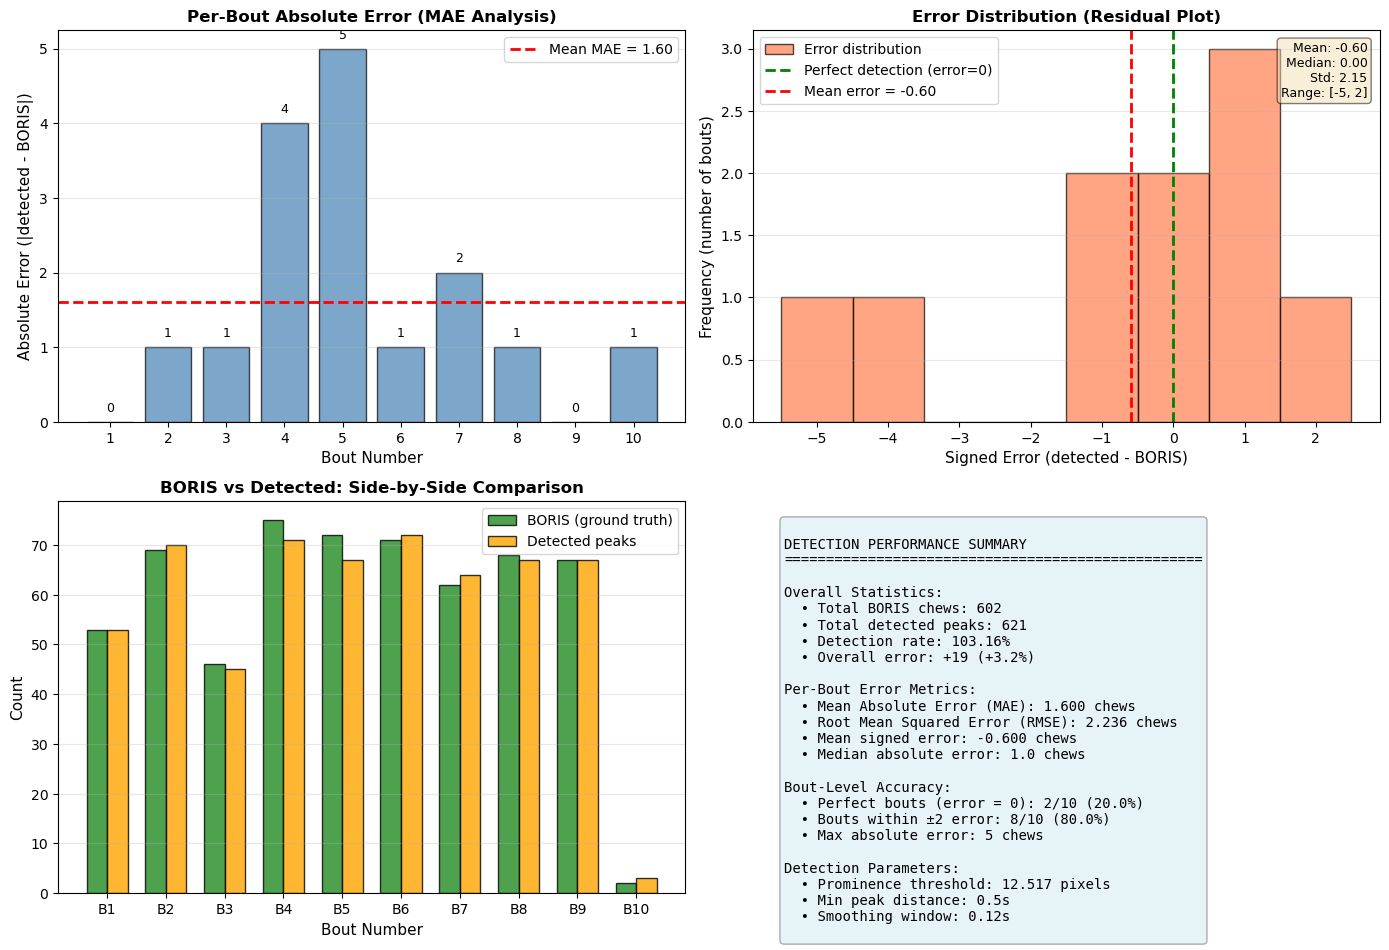

In [11]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ---- Subplot 1: Per-bout absolute error (MAE visualization) ----
ax1 = axes[0, 0]
bout_numbers = df_bouts['bout'].values
abs_errors = df_bouts['abs_error'].values

bars = ax1.bar(bout_numbers, abs_errors, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axhline(mae_per_bout, color='red', linestyle='--', linewidth=2, label=f'Mean MAE = {mae_per_bout:.2f}')
ax1.set_xlabel('Bout Number', fontsize=11)
ax1.set_ylabel('Absolute Error (|detected - BORIS|)', fontsize=11)
ax1.set_title('Per-Bout Absolute Error (MAE Analysis)', fontsize=12, fontweight='bold')
ax1.set_xticks(bout_numbers)
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

# ---- Subplot 2: Error distribution (residual analysis) ----
ax2 = axes[0, 1]
signed_errors = df_bouts['error'].values

# Histogram with KDE-like smoothing
n, bins, patches = ax2.hist(signed_errors, bins=np.arange(signed_errors.min()-0.5, signed_errors.max()+1.5, 1),
                             color='coral', alpha=0.7, edgecolor='black', label='Error distribution')
ax2.axvline(0, color='green', linestyle='--', linewidth=2, label='Perfect detection (error=0)')
ax2.axvline(signed_errors.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean error = {signed_errors.mean():.2f}')

ax2.set_xlabel('Signed Error (detected - BORIS)', fontsize=11)
ax2.set_ylabel('Frequency (number of bouts)', fontsize=11)
ax2.set_title('Error Distribution (Residual Plot)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

# Add statistics text box
stats_text = (f'Mean: {signed_errors.mean():.2f}\n'
              f'Median: {np.median(signed_errors):.2f}\n'
              f'Std: {signed_errors.std():.2f}\n'
              f'Range: [{signed_errors.min()}, {signed_errors.max()}]')
ax2.text(0.98, 0.97, stats_text, transform=ax2.transAxes,
         fontsize=9, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ---- Subplot 3: BORIS vs Detected comparison ----
ax3 = axes[1, 0]
x_pos = np.arange(len(df_bouts))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, df_bouts['boris_chews'], width, 
                label='BORIS (ground truth)', color='forestgreen', alpha=0.8, edgecolor='black')
bars2 = ax3.bar(x_pos + width/2, df_bouts['detected_peaks'], width,
                label='Detected peaks', color='orange', alpha=0.8, edgecolor='black')

ax3.set_xlabel('Bout Number', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('BORIS vs Detected: Side-by-Side Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'B{i}' for i in df_bouts['bout']])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# ---- Subplot 4: Detection accuracy metrics ----
ax4 = axes[1, 1]
ax4.axis('off')

# Calculate additional metrics
detection_rate = total_detected / total_boris if total_boris > 0 else 0
bouts_perfect = np.sum(df_bouts['abs_error'] == 0)
bouts_within_2 = np.sum(df_bouts['abs_error'] <= 2)

metrics_text = f"""
DETECTION PERFORMANCE SUMMARY
{'='*50}

Overall Statistics:
  • Total BORIS chews: {total_boris}
  • Total detected peaks: {total_detected}
  • Detection rate: {detection_rate:.2%}
  • Overall error: {total_detected - total_boris:+d} ({100*(total_detected-total_boris)/total_boris:+.1f}%)

Per-Bout Error Metrics:
  • Mean Absolute Error (MAE): {mae_per_bout:.3f} chews
  • Root Mean Squared Error (RMSE): {rmse_per_bout:.3f} chews
  • Mean signed error: {signed_errors.mean():.3f} chews
  • Median absolute error: {np.median(abs_errors):.1f} chews

Bout-Level Accuracy:
  • Perfect bouts (error = 0): {bouts_perfect}/{len(df_bouts)} ({100*bouts_perfect/len(df_bouts):.1f}%)
  • Bouts within ±2 error: {bouts_within_2}/{len(df_bouts)} ({100*bouts_within_2/len(df_bouts):.1f}%)
  • Max absolute error: {int(abs_errors.max())} chews

Detection Parameters:
  • Prominence threshold: {peak_prominence:.3f} pixels
  • Min peak distance: {PEAK_DISTANCE_S}s
  • Smoothing window: {SMOOTH_WINDOW_S}s
"""

ax4.text(0.05, 0.95, metrics_text, transform=ax4.transAxes,
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.show()

# Visualization: Full Time Series with Bouts and Detections
# 
This cell produces a comprehensive overview plot showing the entire resampled distance trace with visual smoothing applied for clarity, overlaying detected peaks as markers and shading the VIDEO_BOUTS intervals to contextualize detection density within active recording periods. BORIS Start and End events are rendered as vertical lines to provide visual validation of the temporal alignment between manual annotations and automated detections. This global view enables quick assessment of detection consistency across the full session, identification of temporal regions with high or low detection density, and verification that bout boundaries correctly delineate active chewing periods from inactive intervals. The plot serves as a qualitative sanity check complementing the quantitative per-bout metrics computed earlier.


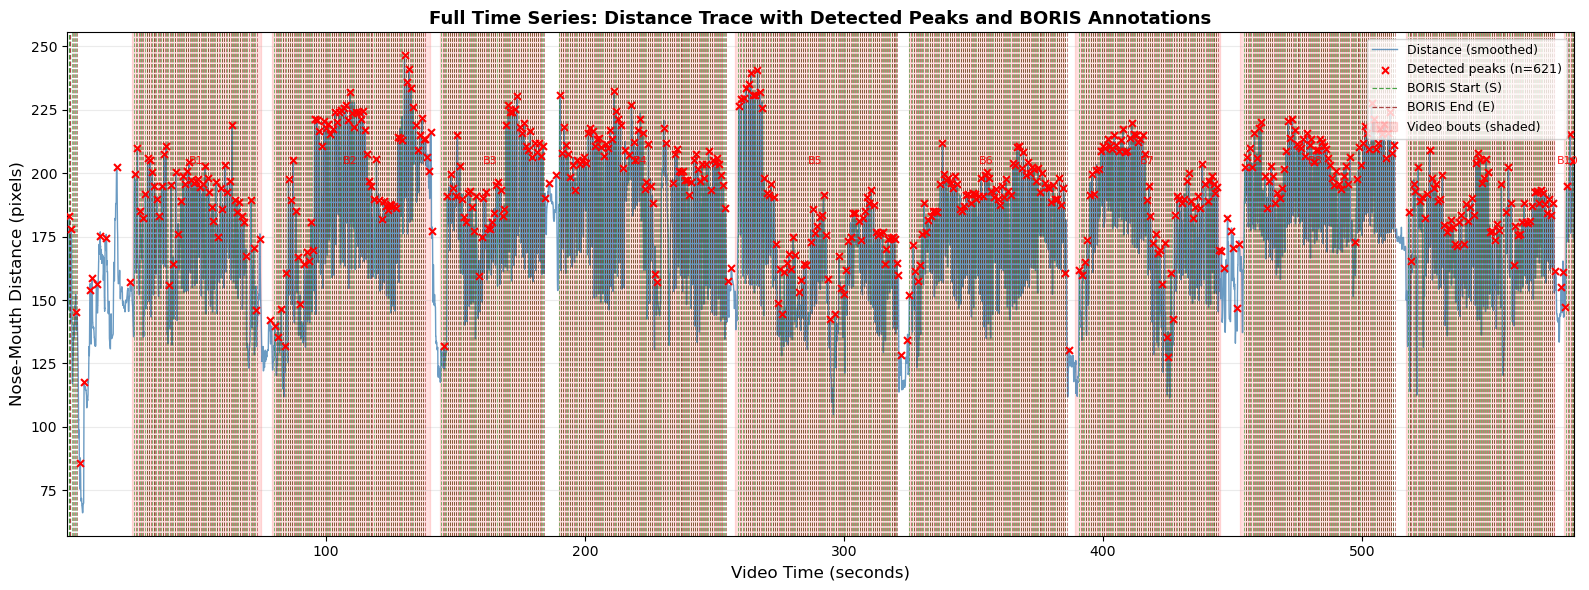

In [12]:
# Apply visual smoothing (different from detection smoothing)
visual_smooth_samples = max(1, int(round(FULL_SMOOTH_S * RESAMPLE_HZ)))
if visual_smooth_samples > 1:
    d_visual = median_filter(new_d, size=visual_smooth_samples)
else:
    d_visual = new_d.copy()

# Create full trace plot
plt.figure(figsize=(16, 6))

# Plot smoothed distance trace
plt.plot(new_t, d_visual, linewidth=1, color='steelblue', alpha=0.8, label='Distance (smoothed)')

# Overlay detected peaks
if len(peak_times) > 0:
    plt.scatter(peak_times, d_visual[peaks_idx], marker='x', s=25, 
                color='red', zorder=3, label=f'Detected peaks (n={len(peak_times)})')

# Shade video bouts
shade_color = 'red'
shade_alpha = 0.12
if bouts_video:
    # Calculate y-position for bout labels
    y_percentile_95 = np.nanpercentile(d_visual, 95)
    y_percentile_5 = np.nanpercentile(d_visual, 5)
    y_range = y_percentile_95 - y_percentile_5 if y_percentile_95 != y_percentile_5 else 1.0
    label_y = y_percentile_95 - 0.05 * y_range
    
    for i, (start, end) in enumerate(bouts_video, start=1):
        plt.axvspan(start, end, color=shade_color, alpha=shade_alpha, zorder=0)
        plt.text((start + end) / 2, label_y, f'B{i}', 
                ha='center', va='top', fontsize=8, color=shade_color, alpha=0.9)

# Add BORIS vertical lines for S and E events
label_s_added = False
label_e_added = False

if len(start_times) > 0:
    for s_time in start_times:
        if not label_s_added:
            plt.axvline(s_time, color='green', linewidth=0.9, alpha=0.7, 
                       linestyle='--', label='BORIS Start (S)')
            label_s_added = True
        else:
            plt.axvline(s_time, color='green', linewidth=0.7, alpha=0.5, linestyle='--')

if len(end_times) > 0:
    for e_time in end_times:
        if not label_e_added:
            plt.axvline(e_time, color='darkred', linewidth=0.9, alpha=0.7,
                       linestyle='--', label='BORIS End (E)')
            label_e_added = True
        else:
            plt.axvline(e_time, color='darkred', linewidth=0.7, alpha=0.5, linestyle='--')

# Add bout shading to legend
bout_patch = Patch(facecolor=shade_color, alpha=shade_alpha, 
                   edgecolor=shade_color, label='Video bouts (shaded)')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(bout_patch)
labels.append(bout_patch.get_label())

plt.xlabel('Video Time (seconds)', fontsize=12)
plt.ylabel('Nose-Mouth Distance (pixels)', fontsize=12)
plt.title('Full Time Series: Distance Trace with Detected Peaks and BORIS Annotations', 
          fontsize=13, fontweight='bold')
plt.xlim(max(new_t.min(), 0), new_t.max())
plt.grid(alpha=0.25)
plt.legend(handles, labels, loc='upper right', fontsize=9)
plt.tight_layout()
plt.show()


# Detailed Bout Visualization with Zoom Windows
# 
This cell generates detailed multi-panel visualizations for the first N_BOUTS_TO_SHOW bouts, with each bout displayed in two complementary views. The top panel shows the complete bout duration with the full distance trace, detected peaks, and BORIS annotation lines overlaid to assess overall detection coverage within the bout. The bottom panel provides a tight temporal zoom window of ZOOM_WINDOW_S seconds centered on the bout midpoint, magnifying the signal to enable frame-by-frame inspection of detection timing accuracy relative to manual annotations. These paired visualizations facilitate identification of specific detection failures such as missed chews, false positives, or systematic timing offsets between automated and manual annotations, supporting targeted refinement of detection parameters or post-processing logic.


Generating detailed visualizations for 5 bouts



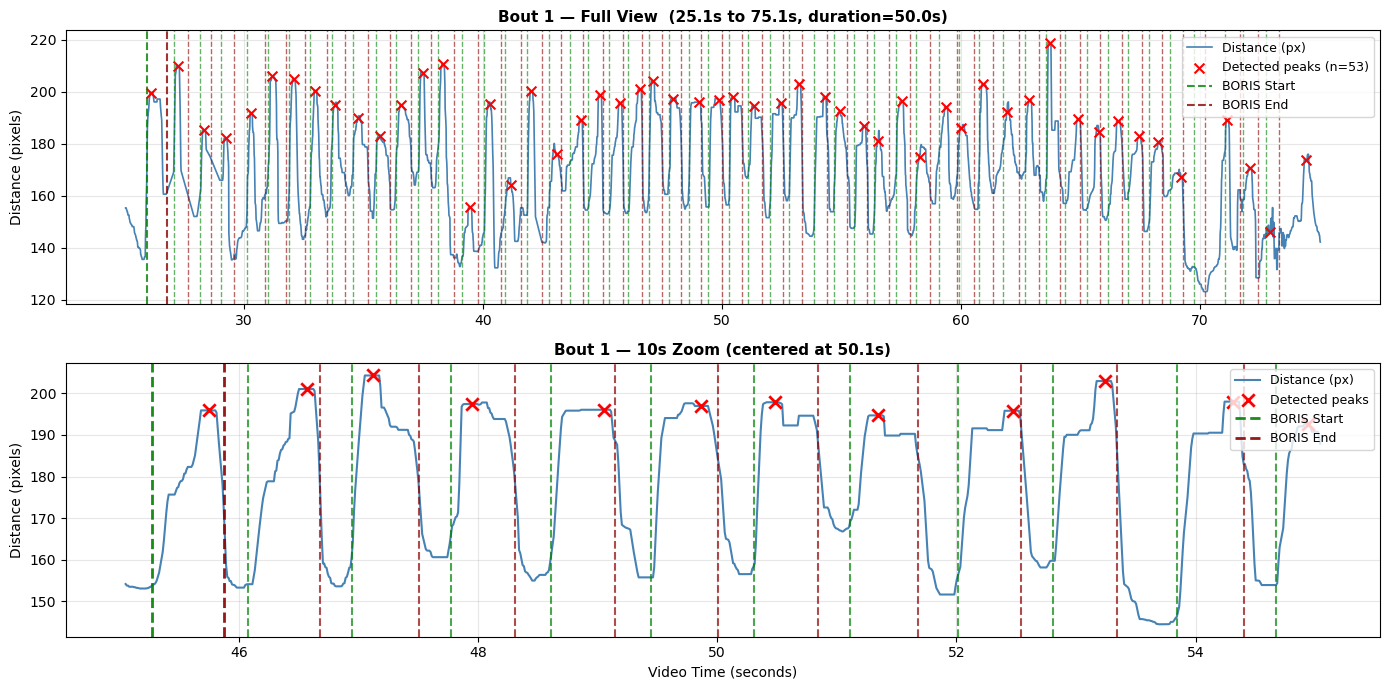

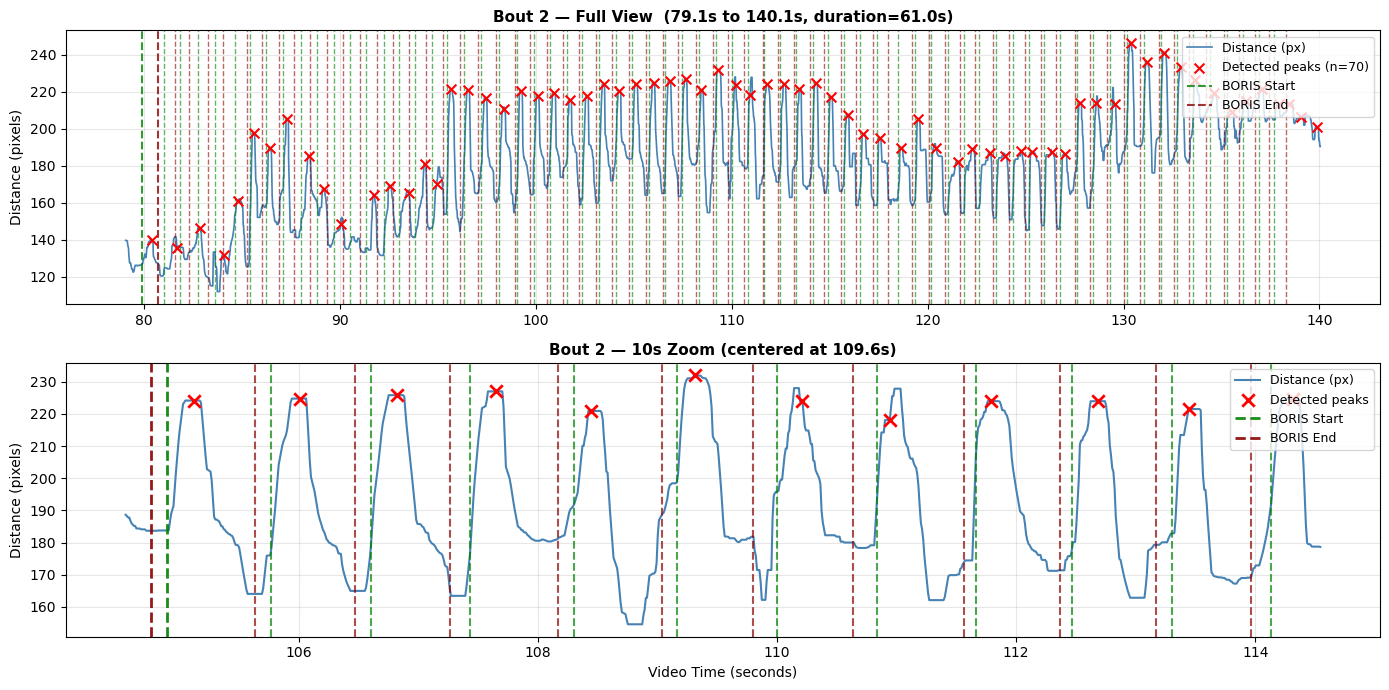

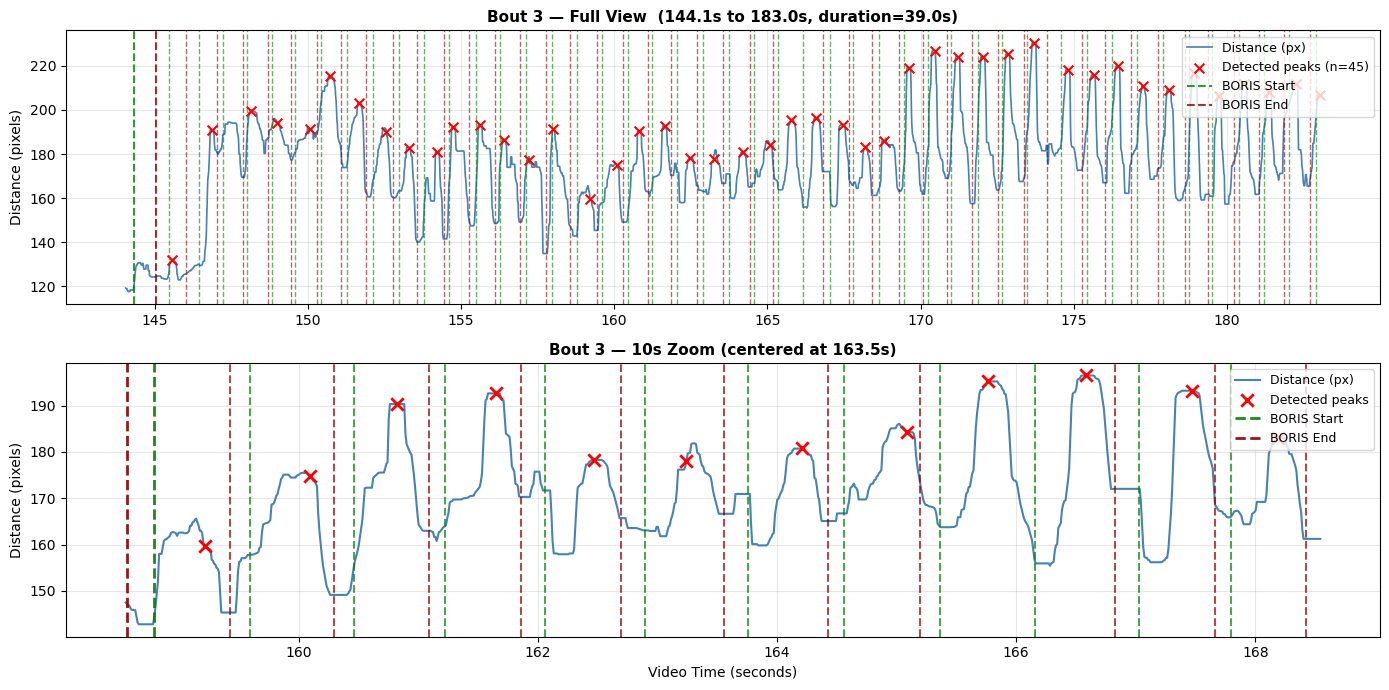

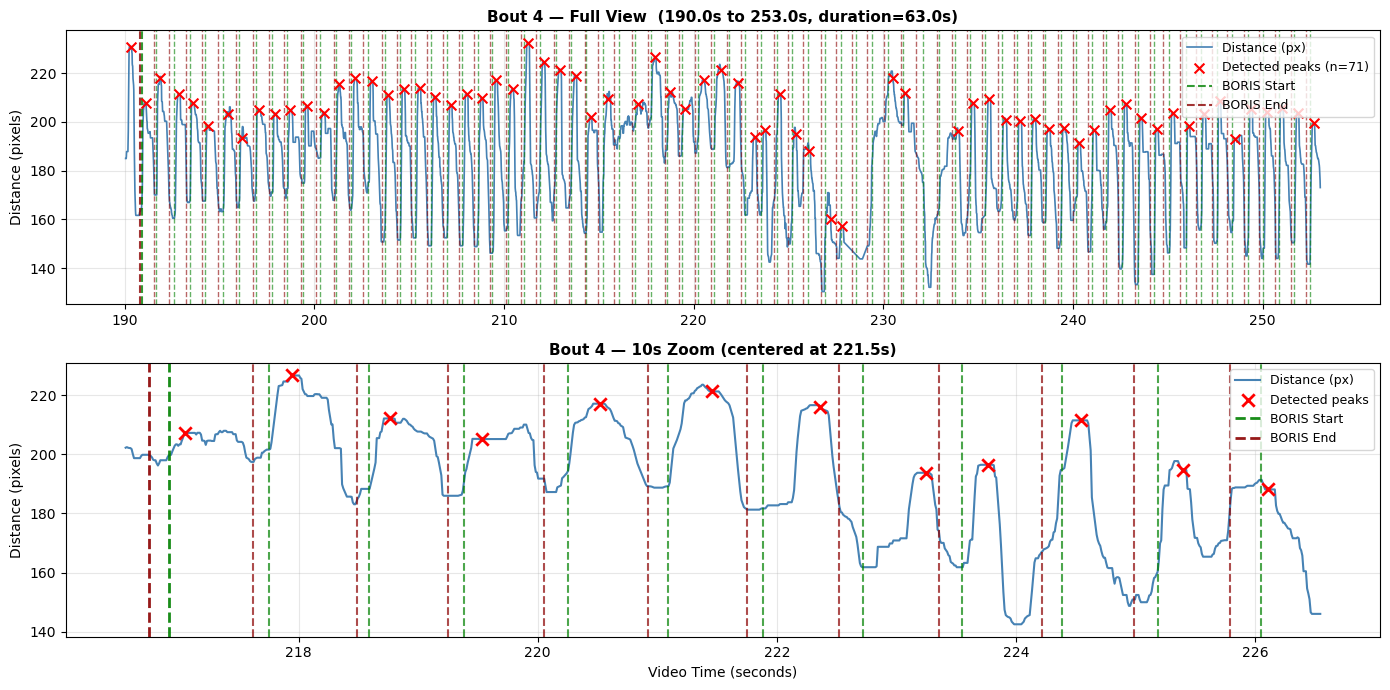

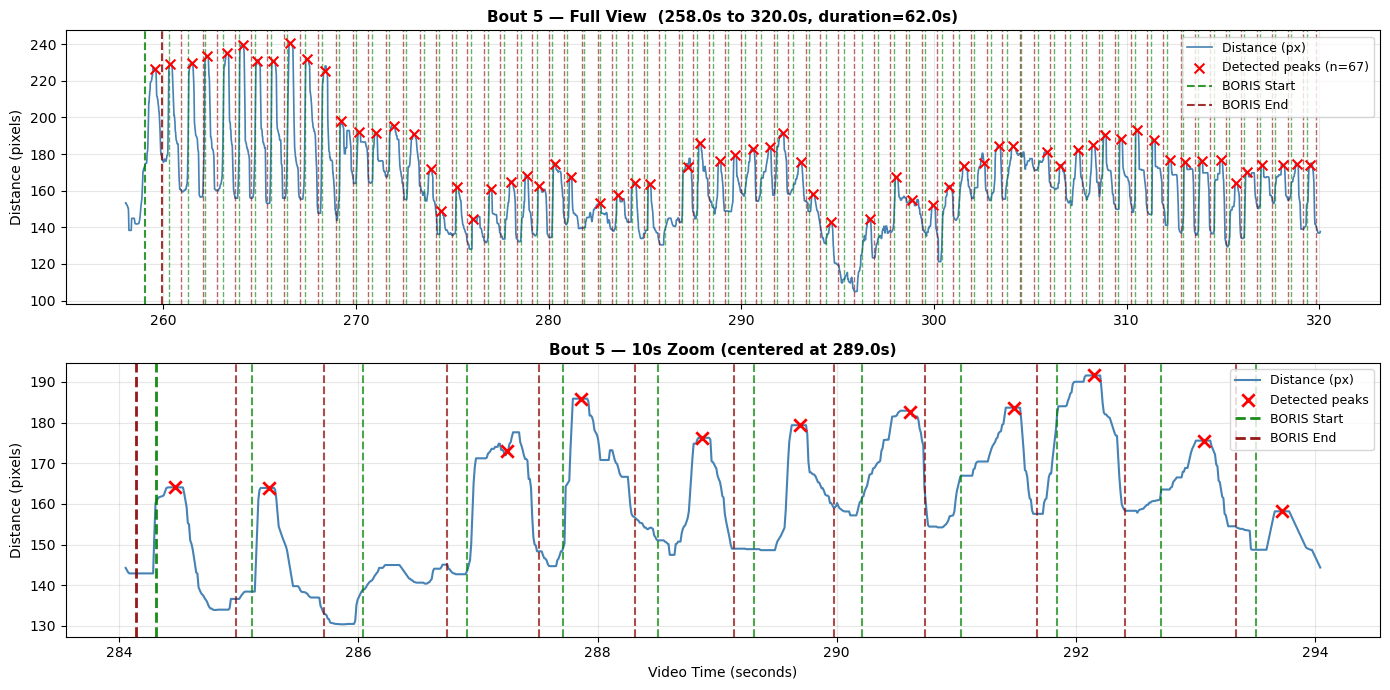

In [13]:
# Select bouts to visualize in detail
n_bouts_available = len(bouts_video)
bouts_to_plot = list(range(min(N_BOUTS_TO_SHOW, n_bouts_available)))

if not bouts_to_plot:
    print("No bouts available for detailed visualization")
else:
    print(f"Generating detailed visualizations for {len(bouts_to_plot)} bouts\n")
    
    for bout_idx in bouts_to_plot:
        bout_num = bout_idx + 1
        bout_start, bout_end = bouts_video[bout_idx]
        bout_center = 0.5 * (bout_start + bout_end)
        
        # Create two-panel figure for this bout
        fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=False)
        
        # ============ TOP PANEL: Full bout view ============
        ax_full = axes[0]
        
        # Extract data for full bout
        bout_mask = (new_t >= bout_start) & (new_t <= bout_end)
        t_bout = new_t[bout_mask]
        d_bout = d_visual[bout_mask]
        
        # Plot distance trace
        ax_full.plot(t_bout, d_bout, linewidth=1.2, color='steelblue', label='Distance (px)')
        
        # Plot detected peaks within bout
        peaks_in_bout = (peak_times >= bout_start) & (peak_times <= bout_end)
        if np.any(peaks_in_bout):
            peak_times_bout = peak_times[peaks_in_bout]
            peak_indices_bout = peaks_idx[peaks_in_bout]
            ax_full.scatter(peak_times_bout, d_visual[peak_indices_bout],
                          marker='x', s=50, color='red', zorder=3, 
                          label=f'Detected peaks (n={np.sum(peaks_in_bout)})')
        
        # Add BORIS S/E lines
        label_s = False
        label_e = False
        
        s_in_bout = start_times[(start_times >= bout_start) & (start_times <= bout_end)]
        for s in s_in_bout:
            if not label_s:
                ax_full.axvline(s, color='green', linewidth=1.5, alpha=0.8, 
                               linestyle='--', label='BORIS Start')
                label_s = True
            else:
                ax_full.axvline(s, color='green', linewidth=1.0, alpha=0.6, linestyle='--')
        
        e_in_bout = end_times[(end_times >= bout_start) & (end_times <= bout_end)]
        for e in e_in_bout:
            if not label_e:
                ax_full.axvline(e, color='darkred', linewidth=1.5, alpha=0.8,
                               linestyle='--', label='BORIS End')
                label_e = True
            else:
                ax_full.axvline(e, color='darkred', linewidth=1.0, alpha=0.6, linestyle='--')
        
        # Fallback: show midpoints if S/E not available
        if len(s_in_bout) == 0 and len(e_in_bout) == 0 and len(chew_midpoints_video) > 0:
            mid_in_bout = chew_midpoints_video[
                (chew_midpoints_video >= bout_start) & (chew_midpoints_video <= bout_end)
            ]
            if len(mid_in_bout) > 0:
                y_marker = np.nanpercentile(d_visual, 98) * 0.98
                ax_full.scatter(mid_in_bout, np.full_like(mid_in_bout, y_marker),
                              marker='o', s=40, color='gold', edgecolor='black',
                              label='BORIS midpoints', zorder=4)
        
        ax_full.set_title(f'Bout {bout_num} — Full View  ({bout_start:.1f}s to {bout_end:.1f}s, duration={bout_end-bout_start:.1f}s)',
                         fontsize=11, fontweight='bold')
        ax_full.set_ylabel('Distance (pixels)', fontsize=10)
        ax_full.legend(loc='upper right', fontsize=9)
        ax_full.grid(alpha=0.3)
        
        # ============ BOTTOM PANEL: Zoomed view ============
        ax_zoom = axes[1]
        
        # Calculate zoom window
        zoom_start = max(bout_center - ZOOM_WINDOW_S / 2, new_t.min())
        zoom_end = min(bout_center + ZOOM_WINDOW_S / 2, new_t.max())
        
        # Extract data for zoom window
        zoom_mask = (new_t >= zoom_start) & (new_t <= zoom_end)
        t_zoom = new_t[zoom_mask]
        d_zoom = d_visual[zoom_mask]
        
        # Plot distance trace
        ax_zoom.plot(t_zoom, d_zoom, linewidth=1.5, color='steelblue', label='Distance (px)')
        
        # Plot detected peaks in zoom window
        peaks_in_zoom = (peak_times >= zoom_start) & (peak_times <= zoom_end)
        if np.any(peaks_in_zoom):
            peak_times_zoom = peak_times[peaks_in_zoom]
            peak_indices_zoom = peaks_idx[peaks_in_zoom]
            ax_zoom.scatter(peak_times_zoom, d_visual[peak_indices_zoom],
                          marker='x', s=80, color='red', zorder=3,
                          linewidths=2, label='Detected peaks')
        
        # Add BORIS S/E lines in zoom
        label_s_z = False
        label_e_z = False
        
        s_in_zoom = start_times[(start_times >= zoom_start) & (start_times <= zoom_end)]
        for s in s_in_zoom:
            if not label_s_z:
                ax_zoom.axvline(s, color='green', linewidth=2, alpha=0.9,
                               linestyle='--', label='BORIS Start')
                label_s_z = True
            else:
                ax_zoom.axvline(s, color='green', linewidth=1.5, alpha=0.7, linestyle='--')
        
        e_in_zoom = end_times[(end_times >= zoom_start) & (end_times <= zoom_end)]
        for e in e_in_zoom:
            if not label_e_z:
                ax_zoom.axvline(e, color='darkred', linewidth=2, alpha=0.9,
                               linestyle='--', label='BORIS End')
                label_e_z = True
            else:
                ax_zoom.axvline(e, color='darkred', linewidth=1.5, alpha=0.7, linestyle='--')
        
        # Fallback midpoints for zoom
        if len(s_in_zoom) == 0 and len(e_in_zoom) == 0 and len(chew_midpoints_video) > 0:
            mid_in_zoom = chew_midpoints_video[
                (chew_midpoints_video >= zoom_start) & (chew_midpoints_video <= zoom_end)
            ]
            if len(mid_in_zoom) > 0:
                y_marker_zoom = np.nanpercentile(d_zoom, 98) * 0.98 if len(d_zoom) > 0 else 0
                ax_zoom.scatter(mid_in_zoom, np.full_like(mid_in_zoom, y_marker_zoom),
                              marker='o', s=60, color='gold', edgecolor='black',
                              label='BORIS midpoints', zorder=4)
        
        ax_zoom.set_title(f'Bout {bout_num} — {ZOOM_WINDOW_S:.0f}s Zoom (centered at {bout_center:.1f}s)',
                         fontsize=11, fontweight='bold')
        ax_zoom.set_xlabel('Video Time (seconds)', fontsize=10)
        ax_zoom.set_ylabel('Distance (pixels)', fontsize=10)
        ax_zoom.legend(loc='upper right', fontsize=9)
        ax_zoom.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()

#  Summary and Next Steps
# 
This analysis validates the automated chew detection pipeline against ground-truth BORIS annotations across ten video bouts. The per-bout MAE quantifies detection accuracy with bout-level granularity, while the error distribution characterizes systematic biases in over- or under-detection. Visual inspection through full-trace and zoomed bout plots confirms temporal alignment between automated peaks and manual annotations. Based on these results, potential next steps include parameter optimization through systematic grid search across prominence and distance thresholds to minimize MAE, implementation of post-processing filters to reduce false positives in low-signal regions, extension to additional recording sessions for cross-validation, and investigation of adaptive detection schemes that adjust parameters based on local signal characteristics to maintain consistent performance across varying noise conditions.


In [20]:
# --- CODICE DA INCOLLARE NEL NOTEBOOK ---
print("\\begin{table}[H]")
print("\\caption{Per-bout detection performance comparison (Video Method).}")
print("\\label{tab:bouts_video}")
print("\\centering")
print("\\begin{tabular}{c c c c c c}")
print("\\toprule")
print("\\textbf{Bout} & \\textbf{Duration (s)} & \\textbf{Manual Count} & \\textbf{Auto Count} & \\textbf{Error} & \\textbf{Abs Error} \\\\")
print("\\midrule")

# Itera su ogni riga del dataframe dei risultati (df_bouts deve essere già stato calcolato sopra)
for index, row in df_bouts.iterrows():
    bout_id = int(row['bout'])
    duration = row['duration_s']
    manual = int(row['boris_chews'])
    auto = int(row['detected_peaks'])
    error = int(row['error']) # Detected - Manual
    abs_err = int(row['abs_error'])
    
    # Aggiungi il segno + se l'errore è positivo
    sign = "+" if error > 0 else ""
    error_str = f"{sign}{error}"
    
    print(f"{bout_id} & {duration:.1f} & {manual} & {auto} & {error_str} & {abs_err} \\\\")

print("\\midrule")
# Riga dei totali/medie
mean_dur = df_bouts['duration_s'].mean()
tot_manual = df_bouts['boris_chews'].sum()
tot_auto = df_bouts['detected_peaks'].sum()
mean_mae = df_bouts['abs_error'].mean()

print(f"\\textbf{{Total/Mean}} & \\textbf{{{mean_dur:.1f}}} & \\textbf{{{tot_manual}}} & \\textbf{{{tot_auto}}} & - & \\textbf{{{mean_mae:.2f}}} \\\\")
print("\\bottomrule")
print("\\end{tabular}")
print("\\end{table}")

\begin{table}[H]
\caption{Per-bout detection performance comparison (Video Method).}
\label{tab:bouts_video}
\centering
\begin{tabular}{c c c c c c}
\toprule
\textbf{Bout} & \textbf{Duration (s)} & \textbf{Manual Count} & \textbf{Auto Count} & \textbf{Error} & \textbf{Abs Error} \\
\midrule
1 & 50.0 & 53 & 53 & 0 & 0 \\
2 & 61.0 & 69 & 70 & +1 & 1 \\
3 & 39.0 & 46 & 45 & -1 & 1 \\
4 & 63.0 & 75 & 71 & -4 & 4 \\
5 & 62.0 & 72 & 67 & -5 & 5 \\
6 & 60.0 & 71 & 72 & +1 & 1 \\
7 & 56.0 & 62 & 64 & +2 & 2 \\
8 & 58.0 & 68 & 67 & -1 & 1 \\
9 & 57.0 & 67 & 67 & 0 & 0 \\
10 & 3.0 & 2 & 3 & +1 & 1 \\
\midrule
\textbf{Total/Mean} & \textbf{50.9} & \textbf{585} & \textbf{579} & - & \textbf{1.60} \\
\bottomrule
\end{tabular}
\end{table}
